
|  |
| ------------------------------------------------------- | 
| ![Tremplin des sciences](images/tremplinColorSmall.png) | 

Cahier d'exercices pour l'enseignement et l'apprentissage de programmation issu de la collection "Climat et météo tremplin pour l'enseignement des sciences" (PIA IFÉ ENS de Lyon - Météofrance ENM Toulouse). Le dispositif clef en main repose sur l'utilisation d'une RaspberryPi chargée avec le système d'exploitation Debian enrichi, fourni par le projet. Les sources et les exécutables sont accessibles dans [l'espace collaboratif de la forge github](https://github.com/g-vidal/CahierDeProgrammes); plus d'information sur les [blogs d'accompagnement](http://blog.climatetmeteo.fr/GerardVidal/) systèmes d'exploitation sur [la page des OS  de Raspberries Pi](http://mediaserv.climatetmeteo.fr/images/RaspBerry/DebianStretchPi3/).  Toutes les ressources issues du projet sont fournies sous licence [Creative Commons](https://creativecommons.org/licenses/by-nc/4.0/) ou sous les licences libres d'origine des outils utilisés. Les ressources  du projet peuvent être utilisées dans tout autre environnement compatible.![licence : Creative Commons](images/Licence.jpg) 

Auteur : G. Vidal

------------------------------------------------------------

# Une approche du changement climatique à Lyon

Ce cahier d'exercices propose plusieurs voies d'exploration d'un jeu de données issues des simulations climatiques de Météofrance. Le lot utilisé  est issu d'une modélisation RCP 2.6. Le travail a été effectué avec la températuremaximale mais il est directement transposable à toutes les variables du modèle. Cette première partie traite de la méhode pour qu'un enseignant puisse extraire les données dont il a besoin d'un fichier commandé sur le site [DRIAS](http://www.drias-climat.fr/). Ce cahier manipule des données multidimensionnelles et doit être réservé à des étudiants avancés si on souhaite l'utiliser en classe. Le dessin des figures a été désactivé dans le dépôt sur la forge pour ne pas alourdir inutilement le fichier transféré.

## Préparation de l'environnement et ouverture du fichier de données

Importer d'abord le module `netcdf4` et `numpy`, attention les majuscules sont impératives pour le nom `netCDF4`. Ces deux modules permettent de traiter  les fichiers multidimensionnels au format netCDF utilisés dans le monde de la météorologie et de l'océanographie principalement.

In [12]:
import netCDF4 as nc
import numpy as np
from datetime import datetime
from array import array
import sys, datetime, os

Importation des données de températures maximales depuis le fichier obtenu auprès du site [DRIAS](https://drias-prod.meteo.fr/okapi/accueil/okapiWebDrias/index.jsp) pour la région lyonnaise et intégration dans un fichier pour le traitement, puis affichage de la description du contenu, de la liste des variables.
L'exemple choisi ici a été réalisé avec une grille de 10 x 10 noeuds centrés sur la ville de Lyon, pour obtenir un jeu de données se reporter au manuel numérique réalisé par E. Le Jan et CArole Larose dans le cadre du projet "Climat et Météo Tremplin pour l'enseignement des sciences". Les deux affichages proposés permettent de vérifier les propriétés  du fichier obtenu ainsi que les variables qui pourront être utilisées. Ces affichages sont facultatifs et peuvent être commentés sans conséquence pour la suite.

In [13]:
tMaxLyon = nc.Dataset('http://geoloc-tremplin.ens-lyon.fr/climato-data/Lyon-1/tsmaxLyon-26-45-85.nc')
#print('Description des données issues du modèle : \n',tMaxLyon,'\n') 
#print('Variables disponibles :',tMaxLyon.variables.keys()) # get all variable names
#print('Taille du tableau tasmax :',tMaxLyon.variables['tasmax'].shape ,'\n') 

## Liste des dimensions et des variables du système de données

À partir de la liste des variables obtenue ci-dessus on renomme les jeux de données de chacune des variables qui seront exploitées apour effectuer les calculs et contrôle de la taille des échantillons. Les affichages proposés permettent de contrôler que les paramètres présents sont effectivement ceux qui sont attendus.

In [14]:
for dim in tMaxLyon.dimensions.items():
    print(dim)
print ('Variables \t  Forme \t\t Taille \t type :  \n')
for var in tMaxLyon.variables.keys() :
    print (var, '\t\t', 
           tMaxLyon.variables[var].dimensions, '\t\t', 
           tMaxLyon.variables[var].shape, '\t', 
           tMaxLyon.variables[var].dtype)


('i', <class 'netCDF4._netCDF4.Dimension'>: name = 'i', size = 10
)
('j', <class 'netCDF4._netCDF4.Dimension'>: name = 'j', size = 10
)
('maxStrlen64', <class 'netCDF4._netCDF4.Dimension'>: name = 'maxStrlen64', size = 64
)
('month', <class 'netCDF4._netCDF4.Dimension'>: name = 'month', size = 13
)
('year', <class 'netCDF4._netCDF4.Dimension'>: name = 'year', size = 95
)
Variables 	  Forme 		 Taille 	 type :  

i 		 ('i',) 		 (10,) 	 int32
j 		 ('j',) 		 (10,) 	 int32
month 		 ('month', 'maxStrlen64') 		 (13, 64) 	 |S1
year 		 ('year',) 		 (95,) 	 int32
lat 		 ('j', 'i') 		 (10, 10) 	 float32
lon 		 ('j', 'i') 		 (10, 10) 	 float32
x 		 ('i',) 		 (10,) 	 int32
y 		 ('j',) 		 (10,) 	 int32
temp_26 		 ('year', 'month', 'j', 'i') 		 (95, 13, 10, 10) 	 float32
temp_45 		 ('year', 'month', 'j', 'i') 		 (95, 13, 10, 10) 	 float32
temp_85 		 ('year', 'month', 'j', 'i') 		 (95, 13, 10, 10) 	 float32


## Création des tableaux de calcul

In [15]:
lyon_tmax26 = tMaxLyon.variables['temp_26']  # variable temperature 
lyon_tmax45 = tMaxLyon.variables['temp_45']  # variable temperature 
lyon_tmax85 = tMaxLyon.variables['temp_85']  # variable temperature 
lyon_month = nc.chartostring(tMaxLyon.variables['month'][:])  # variable temps
lyon_year = tMaxLyon.variables['year']  # variable temps

#test = nc.chartostring(tMaxLyon.variables['month'][:])
#print(test)
#test[:] = nc.chartostring(tMaxLyon.variables['month'][:],encoding='utf-8')
#print(test)

lyon_lat,lyon_lon = tMaxLyon.variables['lat'][:,:], tMaxLyon.variables['lon']  # latitude longitude
lyon_x,lyon_y = tMaxLyon.variables['x'], tMaxLyon.variables['y']  # coordonnées métriques
lyon_gridi,lyon_gridj = tMaxLyon.variables['i'], tMaxLyon.variables['j'] # coordonnées grille Aladin

lenmonths = lyon_month.shape[0]

#print ('\n Taille des tableaux de calcul : \n', 
#       '\ntmax26 : ', lyon_tmax26.shape, lyon_tmax26[44,7,5,5],tMaxLyon.variables['temp_26'][44,7,5,5],
#       '\ntmax45 : ', lyon_tmax45.shape, lyon_tmax45[44,7,5,5],tMaxLyon.variables['temp_45'][44,7,5,5],
#       '\ntmax85 : ', lyon_tmax85.shape, lyon_tmax85[44,7,5,5],tMaxLyon.variables['temp_85'][44,7,5,5],
#       '\n\nyear : ', lyon_year.shape, lyon_year[:],
#       '\nmonth : ', lyon_month.shape, lyon_month[:],
#       '\n\nLat : ', lyon_lat.shape,  lyon_lat[0,:],
#       '\nLon : ', lyon_lon.shape, lyon_lon[0,:],
#       '\n\nX : ', lyon_x.shape, lyon_x[:],
#       '\nY : ', lyon_y.shape, lyon_y[:],
#       '\n\ni : ', lyon_gridi.shape, lyon_gridi[:],
#       '\nj : ', lyon_gridj.shape, lyon_gridj[:])

Définition et affectation des variables où sont copiées les données conservées et où seront stockés les résultats des calculs. (La syntaxe du fichier netCDF reste à  vérifier). Les années seront calculées pendant le calcul principal, les affichages permettent de vérifier la validité des données utilisées.

## Calcul principal des moyennes par mois pour chaque noeud et toutes les années


Les affichages suivants permettent de vérifier  que les données obtenues correspondent au format attendu

### Calculs pour une seule période de  `yearInterval` années

Calcul de la moyenne de températures du mois de `calcMonth` sur `yearInterval` années à partir de l'année `yearBegin` sur les noeuds allant de `(startj,starti)` de taille `(intervalj,intervali)`

In [16]:
# Années
yearBegin = 2010
yearInterval = 30
calcMonth = 4
#  Grille i j
starti = 5
intervali = 4
startj = 2
intervalj = 4
# Variables de calcul
startYear = yearBegin - 2006
endYear = startYear + yearInterval
endi = starti + intervali
endj = startj + intervalj
loc_i = 2
loc_j = 3
locLon = lyon_lon[loc_j,loc_i]
locLat = lyon_lat[loc_j,loc_i]
locMonth = lyon_month[calcMonth]

                          
if not  (startYear >= 0) and (endYear <= lenyears) :
    print('starting year or finishing year out of bounds')
    sys.exit('giving up on year bounds')
#print(gridj[loc_j])
#print(gridi[loc_i])
#print(locLon)
#print(locLat)
#print(locMonth)
#print(startYear,':',endYear,',',calcMonth,',',startj,':',endj,',',starti,':',endi)
#print(temp.shape)
#print(np.mean(temp[startYear:endYear,calcMonth,startj:endj,starti:endi]))

#### Une valeur pour un mois donné
Calcul de la moyenne de températures du mois de `calcMonth` sur `yearInterval` années à partir de l'année `yearBegin` sur les noeuds allant de `(startj,starti)` de taille `(intervalj,intervali)`

In [17]:
moyAreaInterval_26 = np.mean(lyon_tmax26[startYear:endYear,calcMonth,startj:endj,starti:endi]) 
moyAreaInterval_45 = np.mean(lyon_tmax45[startYear:endYear,calcMonth,startj:endj,starti:endi]) 
moyAreaInterval_85 = np.mean(lyon_tmax85[startYear:endYear,calcMonth,startj:endj,starti:endi])
print('\nParamètres :\nAnnée de départ : ', yearBegin, 
      '\tAnnée de fin : ', yearBegin + yearInterval, 
      'Mois calculé : ', lyon_month[calcMonth],
      '\nCoordonnées de la sous-grille : [', starti,',', startj, '] - [', endi,',', endj,']')
print('\n Modèles\n\tScenario 2.6\tScenario 4.5\tScenario 8.5')
print('\t', moyAreaInterval_26, '\t', moyAreaInterval_45, '\t', moyAreaInterval_85)


Paramètres :
Année de départ :  2010 	Année de fin :  2040 Mois calculé :  May 
Coordonnées de la sous-grille : [ 5 , 2 ] - [ 9 , 6 ]

 Modèles
	Scenario 2.6	Scenario 4.5	Scenario 8.5
	 19.968794 	 20.335613 	 20.056074


#### Enregistrement du fichier 13 valeurs (une par mois et année)
Calcul de la moyenne de températures annuelle et de tous les mois sur `yearInterval` années à partir de l'année `yearBegin` sur les noeuds allant de `(startj,starti)` de taille `(intervalj,intervali)`.  Les douze moyennes mensuelles sont suivies de la moyenne annuelle.

In [18]:
slice = lenmonths - 1 # slice = lenmonths pour traiter en plus la moyenne annuelle 
moyAreaInterval = [None] * slice
moyAreaInterval[:] = np.mean(lyon_tmax26[startYear:endYear,:,startj:endj,starti:endi],axis=(0,2,3)) 
#print(moyAreaInterval[0:slice])
with open('moyMonth.txt', 'w') as file :
    for p in range(slice) :
        file.write(lyon_month[p])
        file.write(';')
        file.write(str(moyAreaInterval[p]))
        file.write('\n')

#### préparation de la création de figures
On importe les bibliothèques plotly

In [19]:
import plotly.offline as py
import plotly.graph_objs as go
from plotly import tools

py.init_notebook_mode(connected=True)

#### Création d'une figure bidimensionnelle 
Valeurs moyennes de la température max sur toute la région lyonnaise  au mois de juillet de l'horizon 2040. (Décommenter la dernière ligne du bloc pour afficher la figure)

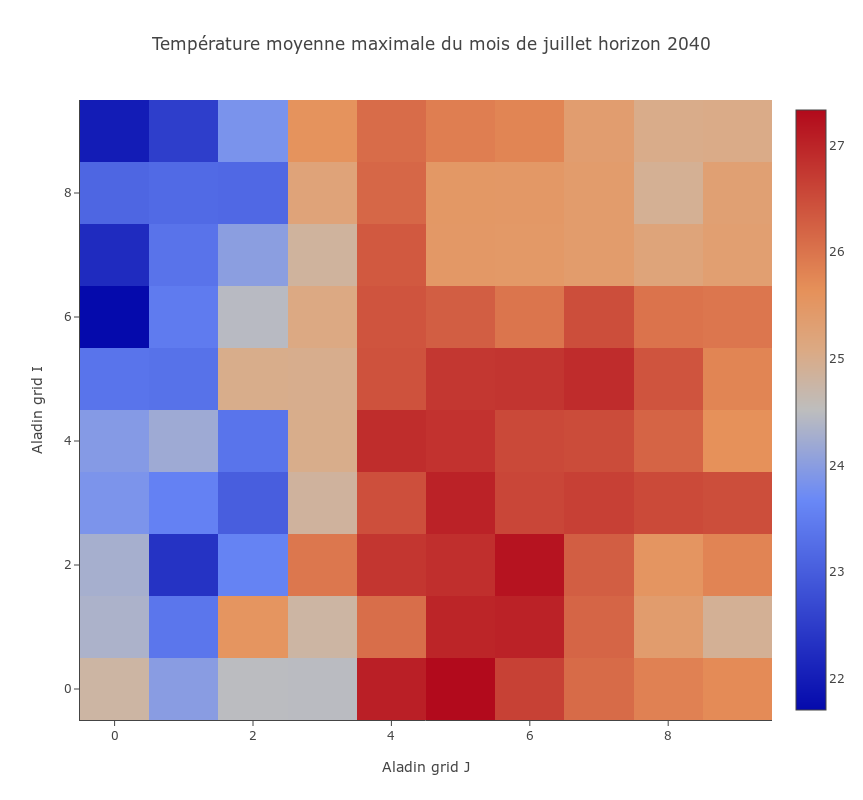

In [20]:
trace0 = go.Heatmap(z=lyon_tmax26[0,6,:,:].tolist())
data=[trace0]
layout = dict (
    title = "Température moyenne maximale du mois de juillet horizon 2040",
    autosize=False,
    width=800,
    height=800,        
    xaxis = dict(
        title = 'Aladin grid J',
        showline=True,
        showticklabels=True,
        ticklen=5
    ),
    yaxis = dict(
        title = 'Aladin grid I',
        showline=True,
        showticklabels=True
    ),         
)
fig = dict(data=data, layout=layout)
py.iplot(fig, filename='basic-heatmap')

#### Comparaison de 3 horizons pour le mois de juillet en région lyonnaise
Ce bloc utilise les données mises en forme dans le bloc précédent pour afficher une comparaison entre  3 horizons. (Décommenter la dernière ligne du bloc pour afficher la figure)

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]  [ (1,3) x3,y3 ]



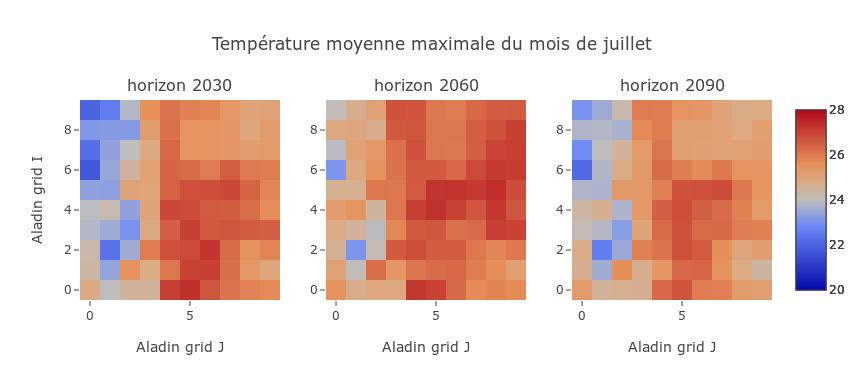

In [22]:
trace0 = go.Heatmap(z=lyon_tmax26[0,6,:,:].tolist(), zauto=False, zmin=20,zmax=28)
trace1 = go.Heatmap(z=lyon_tmax26[49,6,:,:].tolist(), zauto=False, zmin=20,zmax=28)
trace2 = go.Heatmap(z=lyon_tmax26[89,6,:,:].tolist(), zauto=False, zmin=20,zmax=28)

fig = tools.make_subplots(rows=1, cols=3, subplot_titles=('horizon 2030','horizon 2060','horizon 2090'))

fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig.append_trace(trace2, 1, 3)

fig['layout']['xaxis1'].update(title='Aladin grid J')
fig['layout']['xaxis2'].update(title='Aladin grid J')
fig['layout']['xaxis3'].update(title='Aladin grid J')
fig['layout']['yaxis1'].update(title='Aladin grid I')
fig['layout'].update(title='Température moyenne maximale du mois de juillet', 
                     autosize=False, width=800, height=380)  

py.iplot(fig, filename='basic-heatmap')

#### Calcul de la température moyenne maximale  des mois de l'année 2040
On réutilise les paramètres de la tranche de 12 mois (slice) définis plus haut ainsi que les données moyénnées déjà calculées. (Décommenter la dernière ligne du bloc pour afficher la figure)

In [11]:
trace0 = go.Scatter(
    x = lyon_month[0:slice],
    y = moyAreaInterval[0:slice],
    name ='Avril 2040'
)

data = [trace0]

layout = dict (
           title = "Température moyenne maximale des mois de l'année horizon 2040",
           xaxis = dict(
                 title = 'Mois',
                 showline=True,
                 showticklabels=True,
                 ticklen=5
             ),
             yaxis = dict(
                 title = 'Temperature (degrees Celsius)',
                 showline=True,
                 showticklabels=True
             ),         
)


fig = dict(data=data, layout=layout)

py.iplot(fig, filename='basic-line')

#### n X n valeurs pour n² noeuds  pour 12 mois et année
Calcul de la moyenne de températures annuelle et de tous les mois sur `yearInterval` années à partir de l'année `yearBegin` sur chaque noeud allant de `(startj,starti)` de taille `(intervalj,intervali)`.  Les douze moyennes mensuelles sont suivies de la moyenne annuelle. (Décommenter la dernière ligne du bloc pour afficher la figure)

In [12]:
moyAreaInterval = np.zeros((lenmonths,intervalj,intervali))
moyAreaInterval[:] = np.mean(lyon_tmax26[startYear:endYear,:,startj:endj,starti:endi],axis=(0)) 
#print(moyAreaInterval.shape)
#print(moyAreaInterval[:,0,0])
nbnoeuds = intervalj *intervali
data = [] * nbnoeuds
trace = [] * nbnoeuds

In [13]:
for p in range(intervalj) :
    for q in range(intervali) :
        order = p * intervalj + q
        trace = go.Scatter(
            x = lyon_month[0:12],
            y = moyAreaInterval[:,p,q],
            name ='Année 2040 noeud : (%s'%(str(p)+','+str(q)+')')
        )
        data.append(trace)

layout = dict (
           title = "Température moyenne maximale des mois de l'année horizon 2040",
           xaxis = dict(
                 title = 'Mois',
                 showline=True,
                 showticklabels=True,
                 ticklen=5
             ),
             yaxis = dict(
                 title = 'Temperature (degrees Celsius)',
                 showline=True,
                 showticklabels=True
             ),         
)


fig = dict(data=data, layout=layout)

py.iplot(fig, filename='basic-line')

### Calculs pour UNE SÉRIE DE  PÉRIODES de  `yearInterval` années

Calcul de la moyenne de températures des mois de `calcMonth` (il peut y en avoir un seul ou un choix), sur `yearInterval` années à partir de l'année `yearBegin` jusqu'à l'année `yearBegin + yearPeriod` sur les noeuds à partir de `(startj,starti)` de taille `(intervalj,intervali)`. La valeur touvée est affectée à la dernière année de la plage de calcul.

In [14]:
# ASéquence d'années pendant lesquelles les calculs sont effectués
yearBegin = 2010
yearInterval = 30
yearPeriod = 40
calcMonth = [4,5,6,7,8,9]
lencalcMonths = len(calcMonth)
#  Grille i j
starti = 5
intervali = 4
startj = 2
intervalj = 4
# Variables de calcul
startYear = yearBegin - 2006
endYear = startYear + yearInterval
#print(yearPeriodInterval)
endi = starti + intervali
endj = startj + intervalj
loc_i = 2
loc_j = 3
locLon = lyon_lon[loc_j,loc_i]
locLat = lyon_lat[loc_j,loc_i]

                          
if not  (startYear >= 0) and (endYear <= lenyears) :
    print('starting year or finishing year out of bounds')
    sys.exit('giving up on year bounds')
#print(gridj[loc_j])
#print(gridi[loc_i])
#print(locLon)
#print(locLat)
#print(locMonth)
#print(startYear,':',endYear,',',calcMonth,',',startj,':',endj,',',starti,':',endi)
#print(temp.shape)
#print(np.mean(temp[startYear:endYear,calcMonth,startj:endj,starti:endi]))

### Calcul pour n mois sur p périodes de q années pour la zone

Calcul de la moyenne des températures mensuelles sur `yearInterval` ans pendant une période de `yearPeriod` années successives pour une sélection de `calcMonth`  mois.

In [15]:
moyAreaInterval = np.zeros((lencalcMonths,yearPeriod))
for p in range(yearPeriod) :
    a = startYear + p
    b = endYear + p    
    moyAreaInterval[:,p] = np.mean(lyon_tmax26[a:b,calcMonth,startj:endj,starti:endi],axis=(0,2,3)) 
#print(moyAreaInterval)
firstPlotYear = startYear + yearInterval
lastPlotYear = firstPlotYear + yearPeriod
data = [] * lencalcMonths
trace = [] * lencalcMonths

Le diagramme ci-dessous  représente l'évolution sur `yearPeriod` années de la température dans la région Lyonnaise.(Décommenter la dernière ligne du bloc pour afficher la figure)

In [16]:
for q in range(lencalcMonths) :
    trace = go.Scatter(
        x = lyon_year[firstPlotYear:lastPlotYear],
        y = moyAreaInterval[q,:],
        name ='Moyenne du mois %s'%lyon_month[calcMonth[q]]
    )
    data.append(trace)

layout = dict (
           title = "Température moyenne maximale des mois de l'année moyennées sur 30 ans",
           xaxis = dict(
                 title = 'Année',
                 showline=True,
                 showticklabels=True,
                 ticklen=5
             ),
             yaxis = dict(
                 title = 'Temperature (degrees Celsius)',
                 showline=True,
                 showticklabels=True
             ),         
)


fig = dict(data=data, layout=layout)

#py.iplot(fig, filename='basic-line')

### Contrôle du contenu du fichier sauvegardé 
Ce bloc permet d'imprimer le contenu du jeu de données qui vient d'être sauvegardé afin de vérifier qu'il contient les données attendues. le suivant ferme le fichier écrit.

In [17]:
#for dim in extractLyonTempYearMonth.dimensions.items():
#    print(dim[1])
#for var in extractLyonTempYearMonth.variables.keys() :
#    print (var, '\t\t', extractLyonTempYearMonth.variables[var].dimensions, '\t\t', 
#           extractLyonTempYearMonth.variables[var].shape, '\t', extractLyonTempYearMonth.variables[var].dtype)